# Create Initial Island Topography

*(Version GMD210606. Created by Greg Tucker, University of Colorado Boulder.)*

Creates initial topography for a hypothetical oceanic plateau, roughly circular in outline, surrounded by deep water. Used as an initial condition for an example simulation illustrated in a manuscript submitted by Tucker et al. to Geoscientific Modeling Development, summer 2021.

In [51]:
from landlab import HexModelGrid, imshow_grid
from landlab.ca.hex_cts import HexCTS
from landlab.ca.celllab_cts import Transition
import numpy as np

## Initialize

### Set parameters

Use these parameters to control the size and topographic properties of the island:

In [52]:
nrows = 257 # number of rows in grid
ncols = 257 # number of columns
dx = 1000.0 # spacing between grid points, m
fill_proportion = 0.5 # proportion of grid cells that are part of the initial island/plateau
mean_ocean_elev = -2500.0 # average mean elevation (-depth) of sea floor, m
stdev_elev = 400.0 # standard deviation of random noise applied to elevations (pre-smoothing), m
shield_slope = 0.01 # average slope of island topography
smoothing_length = 2000.0 # length scale for diffusive smoothing, m

### Define the PlateauGenerator class

The `PlateauGenerator` is a simple cellular automaton model derived from Landlab's `HexCTS` continuous-time stochastic cellular modeling class, which uses a hexagonal grid. The idea is to use an Eden growth algorithm to create a quasi-circular island. The algorithm starts with a binary hex grid in which all nodes are initially zero ("out") except the middle node, which has the value 1 ("in"). Wherever an "in" node is adjacent to an "out" node (representing a point on the perimeter of the island), there is a fixed probably per unit time that the "out" node will be added to the island (by converting it to an "in") node. With the CTS framework, this is easy to accomplish: just define two transition types, one transitioning from a node pair with (0, 1) to (1, 1), and the other transitioninig from a node pair with (1, 0) to (1, 1). Both transitions are given a unit rate.

The algorithm proceeds until a user-specified target fill proportion (i.e., the proportion of nodes in the grid that are in the "in" state) has been reached or slightly exceeded.

For information about the CTS framework, see [Tucker et al. (2016)](https://doi.org/10.5194/gmd-9-823-2016), and the [online documentation](https://landlab.readthedocs.io/en/latest/user_guide/cell_lab_user_guide.html).

In [53]:
class PlateauGenerator(HexCTS):
    def __init__(
        self, nrows=11, ncols=11, dx=1.0, target_fill_proportion=0.5, dt=1.0, seed=0
    ):

        self.create_grid(nrows, ncols, dx)
        self.node_state = self.grid.at_node["node_state"]
        middle_node = self.grid.number_of_nodes // 2
        self.node_state[middle_node] = 1
        self.target_fill_proportion = target_fill_proportion
        self.dt = dt

        node_state_dict = {0: "out", 1: "in"}
        transition_list = [
            Transition((0, 1, 0), (1, 1, 0), 1.0),
            Transition((1, 0, 0), (1, 1, 0), 1.0),
        ]

        super().__init__(
            self.grid, node_state_dict, transition_list, self.node_state, seed=seed
        )

    def create_grid(self, nrows, ncols, dx):
        """Make the grid."""
        self.grid = HexModelGrid((nrows, ncols), dx, node_layout="rect")
        self.grid.add_zeros("node_state", at="node", dtype=np.int)

    def proportion_filled(self):
        return np.count_nonzero(self.node_state) / self.grid.number_of_core_nodes

    def go(self):
        current_time = 0.0
        prop_filled = self.proportion_filled()
        while prop_filled < self.target_fill_proportion:
            self.run(run_to=current_time + self.dt)
            prop_filled = self.proportion_filled()
            print(str(np.round(100 * prop_filled)) + "% filled")
            current_time += self.dt

## Run

### Create a binary map of island versus sea floor

Run the generator to create a binary map of the island.

In [54]:
pg = PlateauGenerator(nrows=nrows, ncols=ncols, dx=dx, target_fill_proportion=fill_proportion)
pg.go()

<ipython-input-53-a699c50676f9>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.grid.add_zeros("node_state", at="node", dtype=np.int)


0.0% filled
0.0% filled
0.0% filled
1.0% filled
1.0% filled
2.0% filled
2.0% filled
3.0% filled
5.0% filled
6.0% filled
7.0% filled
9.0% filled
11.0% filled
13.0% filled
15.0% filled
17.0% filled
19.0% filled
22.0% filled
25.0% filled
28.0% filled
31.0% filled
34.0% filled
37.0% filled
41.0% filled
44.0% filled
48.0% filled
52.0% filled


/Users/gtucker/Dev/Landlab/landlab/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("pink"))
  cmap.set_bad(color=color_for_closed)


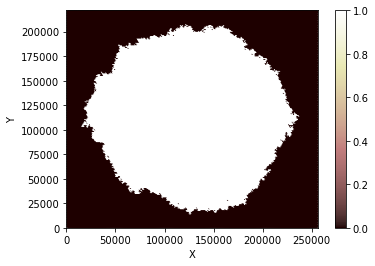

In [55]:
imshow_grid(pg.grid, 'node_state')

### Assign elevations with some random noise

Here we give the island some elevation. The island nodes gets a mean elevation of zero, and the sea floor gets a mean elevation specified above in the parameter `mean_ocean_elev`. To each grid node (except boundaries) we then add a normally distributed random variable with a mean of zero and a standard deviation of `stdev_elev`.

In [56]:
grid = pg.grid
z = grid.add_zeros('topographic__elevation', at='node', clobber=True)
ns = grid.at_node['node_state']

In [57]:
z[ns==1] = stdev_elev * np.random.standard_normal(len(z[ns==1]))
z[ns==0] = mean_ocean_elev + stdev_elev * np.random.standard_normal(len(z[ns==0]))
z[grid.boundary_nodes] = mean_ocean_elev # keep the boundary nodes at the mean sea floor elevation

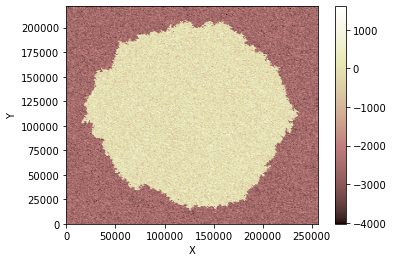

In [58]:
imshow_grid(grid, z)

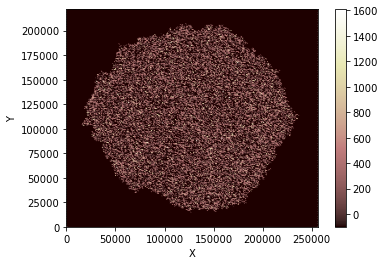

In [59]:
imshow_grid(grid, z, vmin=-100) # highlighting the island

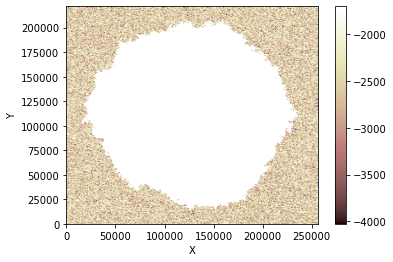

In [60]:
imshow_grid(grid, z, vmax=mean_ocean_elev+2*stdev_elev) # highlighting the sea floor

### Smooth the noisy topography using diffusion

To reduce the "spikiness" of the initial terrain, we'll smooth it using diffusion. Here we'll aim for a length scale of filtering of $\sigma$, which we achieve as follows:

$\sigma = \sqrt{DT}$, where $D=1$ is diffusivity, and $T$ is duration of diffusive smoothing. Example: if we want 5 km of smoothing, then $T = 2.5e7$.

We accomplish this using Landlab's `LinearDiffuser` component.

In [61]:
from landlab.components import LinearDiffuser

In [62]:
duration = smoothing_length ** 2

dt = 0.1 * dx * dx
print('Duration = ' + str(duration) + ', dt = ' + str(dt))

ld = LinearDiffuser(grid, linear_diffusivity=1.0)

Duration = 4000000.0, dt = 100000.0


In [63]:
num_steps = int(duration / dt)
print(str(num_steps) + ' steps')
for i in range(num_steps):
    ld.run_one_step(dt)

40 steps


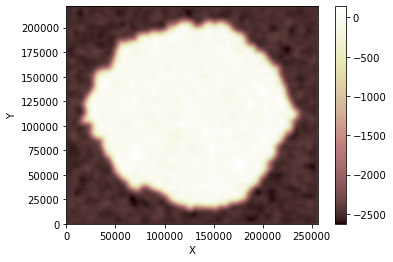

In [64]:
imshow_grid(grid, z) # show smoothed topography

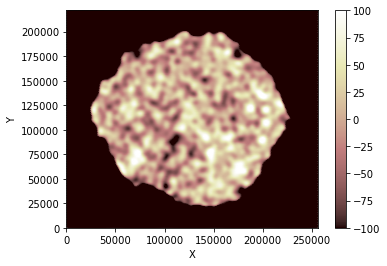

In [65]:
imshow_grid(grid, z, vmin=-100.0, vmax=100.0) # highlighting the island topography

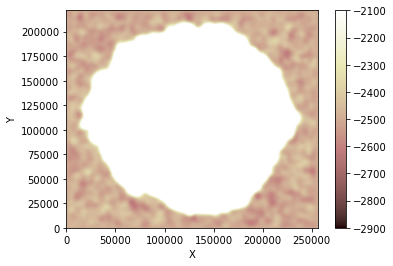

In [66]:
# highlighting the sea floor
imshow_grid(grid, z, vmin=mean_ocean_elev-stdev_elev, vmax=mean_ocean_elev+stdev_elev)

### Modify the topography to give the island a shield-like shape

We now take our smoothed-random topography and give it a shield-like shape. To do this, the `shieldify` function adds a user-specified height to the center-point of the island, and that added height declines linearly with distance from the center point. (This also has the side effect of making the sea floor also slope away from the island, which we might think of as representing the slope of a thermal swell.)

In [67]:
# Function to modify the initial topography
# to make it vaguely shield-shaped
def shieldify(grid, topo, slope, max_add_topo):
    x = grid.x_of_node
    y = grid.y_of_node
    ctr_x = 0.5 * np.amax(x)
    ctr_y = 0.5 * np.amax(y)
    dist = np.sqrt((x - ctr_x)**2 + (y - ctr_y)**2)
    topo[:] += max_add_topo - slope * dist

In [68]:
island_area = fill_proportion * np.amax(grid.x_of_node) * np.amax(grid.y_of_node)
island_radius = (island_area / np.pi) ** 0.5
max_ht = shield_slope * island_radius
shieldify(grid, z, shield_slope, max_ht)

## Finalize

We display the final result, and save it to a file.

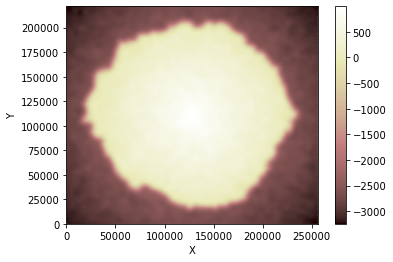

In [69]:
imshow_grid(grid, z)

In [70]:
from landlab.io.native_landlab import save_grid

In [71]:
save_grid(grid, 'initial_island.grid', clobber=True)

Now we're ready to import this grid as an initial condition for a model of landscape/seascape evolution.